In [1]:
from collections import defaultdict
from io import StringIO
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import requests
import seaborn as sns
import numpy as np
import pandas as pd
import scipy.stats as stats
from sklearn.utils import resample
from scipy.stats import pearsonr, ttest_ind, mannwhitneyu, wilcoxon, ranksums, kruskal, zscore
from sklearn.base import BaseEstimator, RegressorMixin, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import BaggingRegressor, HistGradientBoostingRegressor, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor

<!-- Step Project
1. Завантажте цей набір даних IKEA - https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-11-03/ikea.csv. -->

# Step Project

# 1. Завантажте цей набір даних IKEA - https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-11-03/ikea.csv.

In [2]:
import requests

In [3]:
def fetch_data(url):
    response = requests.get(url)

    if response.status_code == 200:
        df = pd.read_csv(StringIO(response.text))
        return df
    else:
        print(f"Failed to fetch data. Status code: {response.status_code}")
        return None

In [4]:
link = "https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-11-03/ikea.csv"

In [5]:
df = fetch_data(link)

In [6]:
df = pd.read_csv("https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-11-03/ikea.csv", index_col=0)


In [7]:
df.head()

,item_id,name,category,price,old_price,sellable_online,link,other_colors,short_description,designer,depth,height,width
0,90420332,FREKVENS,Bar furniture,265.0,No old price,True,https://www.ikea.com/sa/en/p/frekvens-bar-tabl...,No,"Bar table, in/outdoor, 51x51 cm",Nicholai Wiig Hansen,NaN,99.0,51.0
1,368814,NORDVIKEN,Bar furniture,995.0,No old price,False,https://www.ikea.com/sa/en/p/nordviken-bar-tab...,No,"Bar table, 140x80 cm",Francis Cayouette,NaN,105.0,80.0
2,9333523,NORDVIKEN / NORDVIKEN,Bar furniture,2095.0,No old price,False,https://www.ikea.com/sa/en/p/nordviken-nordvik...,No,Bar table and 4 bar stools,Francis Cayouette,NaN,NaN,NaN
3,80155205,STIG,Bar furniture,69.0,No old price,True,https://www.ikea.com/sa/en/p/stig-bar-stool-wi...,Yes,"Bar stool with backrest, 74 cm",Henrik Preutz,50.0,100.0,60.0
4,30180504,NORBERG,Bar furniture,225.0,No old price,True,https://www.ikea.com/sa/en/p/norberg-wall-moun...,No,"Wall-mounted drop-leaf table, ...",Marcus Arvonen,60.0,43.0,74.0


  # 2. Виконайте дослідницький аналіз набору даних, включаючи описову статистику та візуалізації(за бажанням). Опишіть результати. 

In [ ]:
# Частина перша: очистка даних.

In [ ]:
# Пошук дублікатів
# 1) Відбір дублікатів за «item_id»

In [8]:
unique_data = df.drop_duplicates(subset=['item_id'], keep='first').copy()

In [9]:
unique_data['item_id'].is_unique

True

In [9]:
# Очищаємо колонку дизайнер

In [10]:
df.groupby("designer")["designer"].count()

designer
002.756.74 Adjustable hinges allow you to adjust the door horizontally and vertically.Panel/glass doors provide dust-free storage and let you hide or display things according to your needs.Hinges included.Knobs included.Handle with care! A damaged edge or scratched surface can cause the glass to suddenly crack and/or break. Avoid collisions from the side - this is where the glass is most vulnerable.1 door will fit BILLY bookcase 40 cm and 2 doors will fit BILLY bookcase 80 cm.Can be used on the corner unit only if the shelf next to it has no doors.The door does not fit bookcases purchased in the spring of 2014 or earlier.     1
003.494.44 Separate shelf for magazines, etc. helps you keep your things organised and the table top clear.The castors make it easy to move the table if needed.                                                                                                                                                                                                   

In [ ]:
# Прибираємо "/" та залишаємо першого дизайнера

In [11]:
df["designer_clean1"] = (
    df["designer"].astype(str).str.split("/").str[0]
    .str.strip())

In [12]:
# Перевіряємо результат
df.loc[681, ["designer", "designer_clean1"]]

designer           IKEA of Sweden/Jon Karlsson
designer_clean1                 IKEA of Sweden
Name: 681, dtype: object

In [13]:
top_15_designers = (
    df.groupby("designer_clean1")["item_id"].count().sort_values(ascending=False).head(15))
top_15_designers

designer_clean1
IKEA of Sweden          1170
Ehlén Johansson          273
Francis Cayouette        188
Ola Wihlborg             172
K Hagberg                159
Jon Karlsson             148
Ebba Strandmark           96
Carina Bengs              82
Henrik Preutz             77
Nike Karlsson             74
Eva Lilja Löwenhielm      67
Studio Copenhagen         66
H Preutz                  62
K Malmvall                55
Marcus Arvonen            53
Name: item_id, dtype: int64

In [14]:
df.head()

,item_id,name,category,price,old_price,sellable_online,link,other_colors,short_description,designer,depth,height,width,designer_clean1
0,90420332,FREKVENS,Bar furniture,265.0,No old price,True,https://www.ikea.com/sa/en/p/frekvens-bar-tabl...,No,"Bar table, in/outdoor, 51x51 cm",Nicholai Wiig Hansen,NaN,99.0,51.0,Nicholai Wiig Hansen
1,368814,NORDVIKEN,Bar furniture,995.0,No old price,False,https://www.ikea.com/sa/en/p/nordviken-bar-tab...,No,"Bar table, 140x80 cm",Francis Cayouette,NaN,105.0,80.0,Francis Cayouette
2,9333523,NORDVIKEN / NORDVIKEN,Bar furniture,2095.0,No old price,False,https://www.ikea.com/sa/en/p/nordviken-nordvik...,No,Bar table and 4 bar stools,Francis Cayouette,NaN,NaN,NaN,Francis Cayouette
3,80155205,STIG,Bar furniture,69.0,No old price,True,https://www.ikea.com/sa/en/p/stig-bar-stool-wi...,Yes,"Bar stool with backrest, 74 cm",Henrik Preutz,50.0,100.0,60.0,Henrik Preutz
4,30180504,NORBERG,Bar furniture,225.0,No old price,True,https://www.ikea.com/sa/en/p/norberg-wall-moun...,No,"Wall-mounted drop-leaf table, ...",Marcus Arvonen,60.0,43.0,74.0,Marcus Arvonen


In [26]:
# Очищаємо в колонці "Дизайнер" смітєві значення, які починаються з цифри та з обємним описом, 
# залишаємо тільки ті, в яких містяться назви Дизайнерів, все інше - "Unknown". З метою не очищати все на значення "Unknown", 
# можна спробувати використати топ 15 дизайнерів як словник.

In [15]:
top_15_designers = (
    df['designer_clean1'].value_counts().head(15).index.tolist())

In [16]:
import re

In [17]:
def clean_designer(value, top_designers):
    if pd.isna(value):
        return np.nan
    value_str = str(value).strip()
    # якщо починається з цифри
    if re.match(r'^\d', value_str):
        # шукаємо дизайнера з топ-15
        for designer in top_designers:
            if designer in value_str:
                return designer
        return "unknown"
    return value_str

In [18]:
df['designer_clean2'] = df['designer_clean1'].apply(
    lambda x: clean_designer(x, top_15_designers)
)

In [ ]:
# Перевіряємо код

In [19]:
df[df["designer"].str.match(r"^\d", na=False)][
    ["designer", "designer_clean2"]
].head(10)

,designer,designer_clean2
51,504.689.53 Small and easy-to-place chair-bed w...,unknown
77,903.310.91 The door can be hung with the openi...,unknown
104,443.610.10 Easy to keep clean since you can re...,unknown
122,"702.842.03 A sofa-bed with small, neat dimensi...",unknown
132,902.994.49 A good solution where space is limi...,unknown
274,502.638.38 Shallow shelves help you to use sma...,unknown
316,392.873.98 Glass doors keep your favourite ite...,unknown
327,204.099.36 Choose whether you want to place it...,unknown
337,602.957.06 With a media shelf you can make the...,unknown
382,104.283.32 Suitable for both indoor and outdoo...,unknown


In [19]:
df.head()

,item_id,name,category,price,old_price,sellable_online,link,other_colors,short_description,designer,depth,height,width,designer_clean1,designer_clean2
0,90420332,FREKVENS,Bar furniture,265.0,No old price,True,https://www.ikea.com/sa/en/p/frekvens-bar-tabl...,No,"Bar table, in/outdoor, 51x51 cm",Nicholai Wiig Hansen,NaN,99.0,51.0,Nicholai Wiig Hansen,Nicholai Wiig Hansen
1,368814,NORDVIKEN,Bar furniture,995.0,No old price,False,https://www.ikea.com/sa/en/p/nordviken-bar-tab...,No,"Bar table, 140x80 cm",Francis Cayouette,NaN,105.0,80.0,Francis Cayouette,Francis Cayouette
2,9333523,NORDVIKEN / NORDVIKEN,Bar furniture,2095.0,No old price,False,https://www.ikea.com/sa/en/p/nordviken-nordvik...,No,Bar table and 4 bar stools,Francis Cayouette,NaN,NaN,NaN,Francis Cayouette,Francis Cayouette
3,80155205,STIG,Bar furniture,69.0,No old price,True,https://www.ikea.com/sa/en/p/stig-bar-stool-wi...,Yes,"Bar stool with backrest, 74 cm",Henrik Preutz,50.0,100.0,60.0,Henrik Preutz,Henrik Preutz
4,30180504,NORBERG,Bar furniture,225.0,No old price,True,https://www.ikea.com/sa/en/p/norberg-wall-moun...,No,"Wall-mounted drop-leaf table, ...",Marcus Arvonen,60.0,43.0,74.0,Marcus Arvonen,Marcus Arvonen


In [20]:
# Перевірка, як спрацював код
df.loc[679, ["designer_clean1", "designer_clean2"]]

designer_clean1    203.305.99 The TV-bracket can be angled for ch...
designer_clean2                                              unknown
Name: 679, dtype: object

In [21]:
top_15_designers = (
    df.groupby("designer_clean2")["item_id"].count().sort_values(ascending=False).head(15))
top_15_designers

designer_clean2
IKEA of Sweden          1170
Ehlén Johansson          273
Francis Cayouette        188
Ola Wihlborg             172
K Hagberg                159
Jon Karlsson             148
unknown                  143
Ebba Strandmark           96
Carina Bengs              82
Henrik Preutz             77
Nike Karlsson             74
Eva Lilja Löwenhielm      67
Studio Copenhagen         66
H Preutz                  62
K Malmvall                55
Name: item_id, dtype: int64

In [ ]:
# Попередньо робили перевірку колонки "Дизайнерів", замінили всі рядки, які починаються з цифри на "Uknokwn"

In [22]:
df["designer_clean"] = df["designer"].copy()


In [23]:
df["designer_clean"] = df["designer_clean"].apply(lambda x: "unknown" if str(x).strip()[0].isdigit() else x)
# Перевіримо результат
df[["designer", "designer_clean"]].iloc[51]

designer          504.689.53 Small and easy-to-place chair-bed w...
designer_clean                                              unknown
Name: 51, dtype: object

In [24]:
df.groupby("designer_clean")["designer_clean"].count()

designer_clean
A Fredriksson/J Hultqvist/W Chong      7
A Huldén/S Dahlman                     1
Andreas Fredriksson                   26
Anna Efverlund                         3
Anna Palleschitz                       2
                                    ... 
Tord Björklund                        31
Tord Björklund/IKEA of Sweden         12
Virgil Abloh                           5
Wiebke Braasch                         2
unknown                              143
Name: designer_clean, Length: 280, dtype: int64

In [24]:
df.head()

,item_id,name,category,price,old_price,sellable_online,link,other_colors,short_description,designer,depth,height,width,designer_clean1,designer_clean2,designer_clean
0,90420332,FREKVENS,Bar furniture,265.0,No old price,True,https://www.ikea.com/sa/en/p/frekvens-bar-tabl...,No,"Bar table, in/outdoor, 51x51 cm",Nicholai Wiig Hansen,NaN,99.0,51.0,Nicholai Wiig Hansen,Nicholai Wiig Hansen,Nicholai Wiig Hansen
1,368814,NORDVIKEN,Bar furniture,995.0,No old price,False,https://www.ikea.com/sa/en/p/nordviken-bar-tab...,No,"Bar table, 140x80 cm",Francis Cayouette,NaN,105.0,80.0,Francis Cayouette,Francis Cayouette,Francis Cayouette
2,9333523,NORDVIKEN / NORDVIKEN,Bar furniture,2095.0,No old price,False,https://www.ikea.com/sa/en/p/nordviken-nordvik...,No,Bar table and 4 bar stools,Francis Cayouette,NaN,NaN,NaN,Francis Cayouette,Francis Cayouette,Francis Cayouette
3,80155205,STIG,Bar furniture,69.0,No old price,True,https://www.ikea.com/sa/en/p/stig-bar-stool-wi...,Yes,"Bar stool with backrest, 74 cm",Henrik Preutz,50.0,100.0,60.0,Henrik Preutz,Henrik Preutz,Henrik Preutz
4,30180504,NORBERG,Bar furniture,225.0,No old price,True,https://www.ikea.com/sa/en/p/norberg-wall-moun...,No,"Wall-mounted drop-leaf table, ...",Marcus Arvonen,60.0,43.0,74.0,Marcus Arvonen,Marcus Arvonen,Marcus Arvonen


In [25]:
top_15_designers = (df.groupby("designer_clean")["item_id"].count().sort_values(ascending=False).head(15))
top_15_designers

designer_clean
IKEA of Sweden                    828
Ehlén Johansson                   161
Francis Cayouette                 151
unknown                           143
Ola Wihlborg                      134
K Hagberg/M Hagberg               122
Jon Karlsson                      120
Ehlén Johansson/IKEA of Sweden     75
Carina Bengs                       75
IKEA of Sweden/Ehlén Johansson     70
Henrik Preutz                      70
Studio Copenhagen                  64
H Preutz/A Fredriksson             60
Ebba Strandmark                    57
K Malmvall/E Lilja Löwenhielm      55
Name: item_id, dtype: int64

In [25]:
# Фінальні топ 15 дизайнерів після очисток, беремо останю очистку за колонкою "designer_clean2"
top_15_designers = (df.groupby("designer_clean2")["item_id"].count().sort_values(ascending=False).head(15))
top_15_designers

designer_clean2
IKEA of Sweden          1170
Ehlén Johansson          273
Francis Cayouette        188
Ola Wihlborg             172
K Hagberg                159
Jon Karlsson             148
unknown                  143
Ebba Strandmark           96
Carina Bengs              82
Henrik Preutz             77
Nike Karlsson             74
Eva Lilja Löwenhielm      67
Studio Copenhagen         66
H Preutz                  62
K Malmvall                55
Name: item_id, dtype: int64

In [ ]:
# Частина друга: описова статистика. 

In [33]:
df.shape

(3694, 16)

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3694 entries, 0 to 3693
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   item_id            3694 non-null   int64  
 1   name               3694 non-null   object 
 2   category           3694 non-null   object 
 3   price              3694 non-null   float64
 4   old_price          3694 non-null   object 
 5   sellable_online    3694 non-null   bool   
 6   link               3694 non-null   object 
 7   other_colors       3694 non-null   object 
 8   short_description  3694 non-null   object 
 9   designer           3694 non-null   object 
 10  depth              2231 non-null   float64
 11  height             2706 non-null   float64
 12  width              3105 non-null   float64
 13  designer_clean1    3694 non-null   object 
 14  designer_clean2    3694 non-null   object 
 15  designer_clean     3694 non-null   object 
dtypes: bool(1), float64(4), int64

In [26]:
price_descriptive_stats = df["price"].describe()
price_descriptive_stats

count    3694.000000
mean     1078.208419
std      1374.652494
min         3.000000
25%       180.900000
50%       544.700000
75%      1429.500000
max      9585.000000
Name: price, dtype: float64

In [27]:
# Convert to Markdown
%pip install tabulate

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: D:\python_kernel\Scripts\python.exe -m pip install --upgrade pip


In [27]:
price_descriptive_stats_markdown = price_descriptive_stats.to_markdown()
price_descriptive_stats_markdown

'|       |   price |\n|:------|--------:|\n| count | 3694    |\n| mean  | 1078.21 |\n| std   | 1374.65 |\n| min   |    3    |\n| 25%   |  180.9  |\n| 50%   |  544.7  |\n| 75%   | 1429.5  |\n| max   | 9585    |'

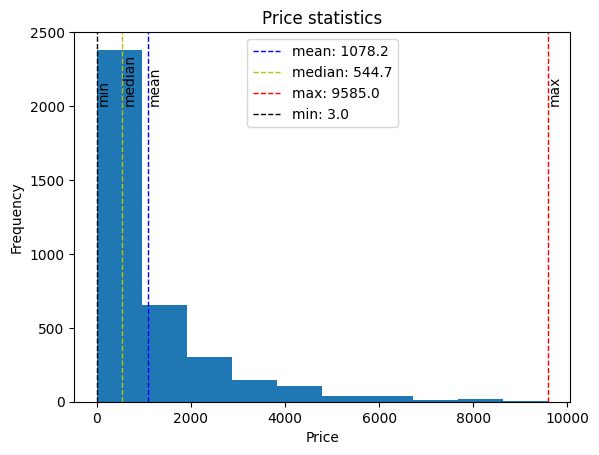

In [28]:
plt.hist(df["price"], bins=10)
plt.title("Price statistics")
plt.xlabel("Price")
plt.ylabel("Frequency")

plt.axvline(df["price"].mean(), color='b', linestyle='dashed', linewidth=1,
            label="mean: {:.1f}".format(df["price"].mean()))
plt.axvline(df["price"].median(), color='y', linestyle='dashed', linewidth=1,
            label="median: {:.1f}".format(df["price"].median()))
plt.axvline(df["price"].max(), color='r', linestyle='dashed', linewidth=1,
            label="max: {:.1f}".format(df["price"].max()))
plt.axvline(df["price"].min(), color='black', linestyle='dashed', linewidth=1,
            label="min: {:.1f}".format(df["price"].min()))

plt.text(df["price"].mean(), 2020, "mean", rotation=90, va="baseline")
plt.text(df["price"].median(), 2020, "median", rotation=90, va="baseline")
plt.text(df["price"].max(), 2020, "max", rotation=90, va="baseline")
plt.text(df["price"].min(), 2020, "min", rotation=90, va="baseline")

plt.legend()
plt.show()

In [ ]:
# Графік показує, де на графіку знаходяться ключові статистики цін
# 	•	дозволяє візуально порівняти розподіл цін із:
# 	•	середнім значенням
# 	•	медіаною
# 	•	мінімумом і максимумом

In [ ]:
# 2.1 Ціни та виробники

# Інформація про продукцію: назви виробників та кількість товарів за назвою

In [28]:
df["name"].unique()
value_counts_by_name = df.groupby("name")["price"].agg(["count"]).reset_index()
value_counts_by_name = value_counts_by_name[value_counts_by_name['count'] >= 30]\
    .sort_values('count', ascending=False).reset_index(drop=True)

In [41]:
# Convert to Markdown
value_counts_by_name_markdown = value_counts_by_name.to_markdown(index=False)
print(value_counts_by_name_markdown)

| name            |   count |
|:----------------|--------:|
| BESTÅ           |     173 |
| PAX             |     111 |
| GRÖNLID         |      83 |
| TROFAST         |      74 |
| BEKANT          |      74 |
| IVAR            |      69 |
| VIMLE           |      63 |
| EKET            |      61 |
| PLATSA          |      57 |
| LIDHULT         |      52 |
| JONAXEL         |      50 |
| NORDLI          |      46 |
| HAVSTA          |      44 |
| HEMNES          |      42 |
| STUVA / FRITIDS |      42 |
| ELVARLI         |      41 |
| KALLAX          |      39 |
| VALLENTUNA      |      38 |
| ALGOT           |      36 |
| BROR            |      34 |
| ÄPPLARÖ         |      34 |
| NORSBORG        |      31 |
| BRIMNES         |      30 |
| BILLSBRO        |      30 |


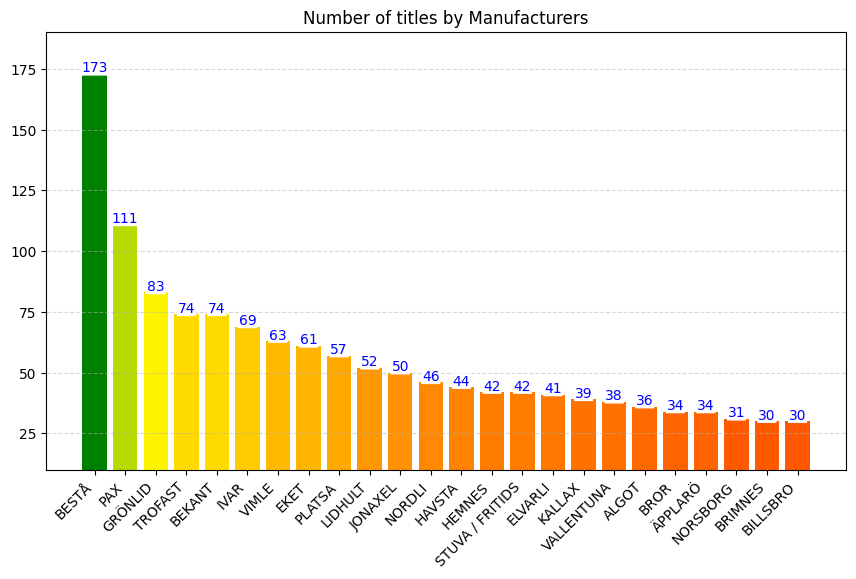

In [32]:
plt.figure(figsize=(10, 6))
gradient_colors = mcolors.LinearSegmentedColormap.from_list("", ["red", "yellow", "green"])
plt.bar(value_counts_by_name['name'], value_counts_by_name['count'],
        color=gradient_colors(value_counts_by_name['count'] / value_counts_by_name['count'].max()))

plt.grid(axis='y', linestyle='--', alpha=0.5)
for i, v in enumerate(value_counts_by_name['count']):
    plt.text(i, v + 2.5, str(v), ha='center', va='center', color="b",
             bbox=dict(facecolor='white', edgecolor='w', boxstyle='round,pad=0.01'))

plt.xticks(rotation=45, ha='right', fontsize=10)
plt.title("Number of titles by Manufacturers")
plt.xlabel("")
plt.ylabel("")
plt.grid(axis='y', linestyle='--')
plt.ylim(10, value_counts_by_name['count'].max() * 1.1)
plt.subplots_adjust(bottom=0.15, left=0.1)

plt.show()

In [ ]:
# Побудовано стовпчикову діаграму кількості товарів за виробниками з використанням градієнтного кольору, де інтенсивність кольору 
# відображає величину показника.Над кожним стовпчиком додано числове значення для кращої інтерпретації результатів.

<!-- 3. На основі EDA та вашого здорового глузду виберіть дві гіпотези, які ви хочете перевірити/проаналізувати.
Для кожної гіпотези перерахуйте нульову гіпотезу та інші можливі альтернативні гіпотези, 
розробіть тести для їх розрізнення та виконайте їх. Опишіть результати. --> -->

In [ ]:
# Ціни та розміри

In [30]:
# Розрахуємо кореляцію між ціною та обсягом товарів
df['size'] = df['width'] * df["depth"] * df["height"]
correlation = df["price"].corr(df['size'])
print(correlation)

0.8305755969257602


In [31]:
# Обчислити «розмір» і знайдемо за розміром outliers
z_scores = zscore(df['size'])
outliers = (z_scores > 3)
size_outliers_data = df[outliers]

In [32]:
# Convert to Markdown
size_outliers_data_markdown = size_outliers_data.to_markdown(index=False)
print(size_outliers_data_markdown)

| item_id   | name   | category   | price   | old_price   | sellable_online   | link   | other_colors   | short_description   | designer   | depth   | height   | width   | designer_clean1   | designer_clean2   | designer_clean   | size   |
|-----------|--------|------------|---------|-------------|-------------------|--------|----------------|---------------------|------------|---------|----------|---------|-------------------|-------------------|------------------|--------|


In [33]:
# Видалити outliers
size_outlemove iers_index = df.index[outliers]
data_without_size_outliers = df[~df.index.isin(size_outliers_index)].copy()

# Convert to Markdown
data_without_size_outliers_markdown = data_without_size_outliers.to_markdown(index=False)
print(data_without_size_outliers_markdown)

SyntaxError: invalid syntax (3121767389.py, line 2)

In [47]:
# Convert to Markdown
data_without_size_outliers_markdown = data_without_size_outliers.to_markdown(index=False)
print(data_without_size_outliers_markdown)

NameError: name 'data_without_size_outliers' is not defined

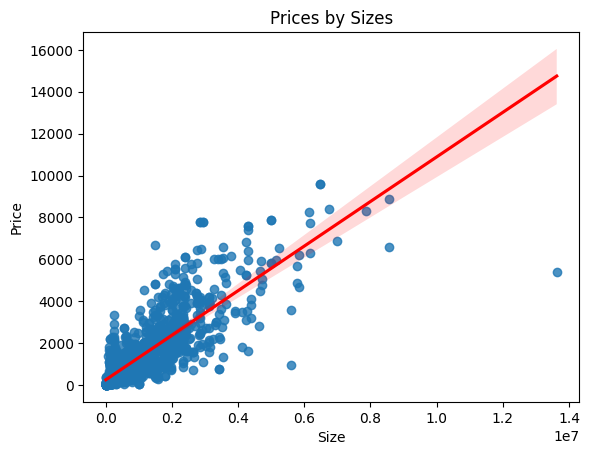

       price  depth  height  width
3       69.0   50.0   100.0   60.0
4      225.0   60.0    43.0   74.0
5      345.0   45.0    91.0   40.0
6      129.0   44.0    95.0   50.0
8      129.0   44.0    95.0   50.0
...      ...    ...     ...    ...
3683  1260.0   60.0   201.0   75.0
3684  1245.0   55.0   216.0  164.0
3685  2100.0   60.0   236.0  100.0
3686  3985.0   66.0   236.0  150.0
3688  2045.0   66.0   236.0  200.0

[1899 rows x 4 columns]


In [33]:
# Точковий графік з лінією регресії
sns.regplot(x=data_without_size_outliers['size'], y=data_without_size_outliers['price'], line_kws={"color": "red"})
plt.title('Prices by Sizes')
plt.xlabel('Size')
plt.ylabel('Price')
plt.show()

data_without_size_outliers = data_without_size_outliers[["price", "depth", "height", "width"]]
data_without_size_outliers = data_without_size_outliers.dropna(subset=["depth", "height", "width"])
print(data_without_size_outliers)

In [15]:
# Median ціна залежно від імені дизайнера
digit_mask =df['designer'].str.contains(r'\d')
digit_designer_data = df[~digit_mask].reset_index(drop=True)
median_price_designer = digit_designer_data.groupby("designer")["price"].median().reset_index()
median_price_designer = median_price_designer.sort_values('price', ascending=False).reset_index(drop=True)
median_price_designer = median_price_designer.iloc[:16]

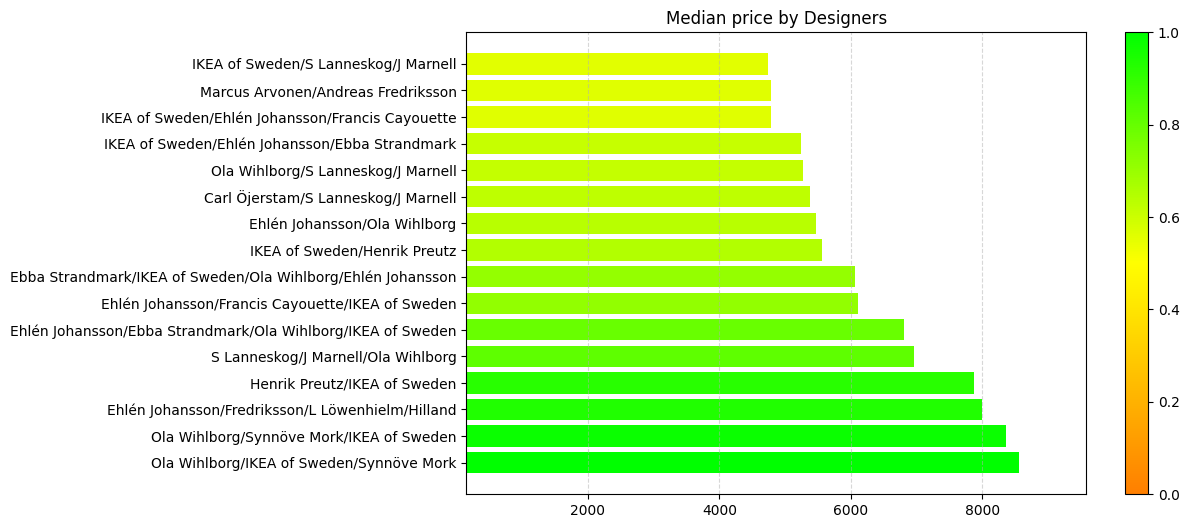

In [16]:
# Візуалізація Median ціни за дизайнерами 
fig, ax = plt.subplots(figsize=(10, 6))
cmap = mcolors.LinearSegmentedColormap.from_list("", ["#FF7F00", "#FFFF00", "#00FF00"])
bar_heights = np.arange(len(median_price_designer))
bar_widths = median_price_designer['price']
colors = cmap(median_price_designer['price']/median_price_designer['price'].max())

ax.barh(bar_heights, bar_widths, color=colors)

sm = plt.cm.ScalarMappable(cmap=cmap)
sm.set_array([])
fig.colorbar(sm, ax=ax)

ax.set_xlim(150, median_price_designer['price'].max() * 1.12)
ax.set_yticks(bar_heights)
ax.set_yticklabels(median_price_designer['designer'])
plt.title("Median price by Designers")
plt.ylabel("")
plt.xlabel("")

plt.grid(axis='x', linestyle='--', alpha=0.5)

| name                        |   price |
|:----------------------------|--------:|
| KONGSFJORD                  |  8453.5 |
| PAX / TYSSEDAL              |  6065   |
| VEDBO / VEDBO               |  5865   |
| MÖRBYLÅNGA / TOSSBERG       |  5465   |
| EKEDALEN / BERNHARD         |  5465   |
| MÖRBYLÅNGA / BALTSAR        |  5370   |
| MÖRBYLÅNGA / BERNHARD       |  5275   |
| PAX / VINTERBRO             |  4390   |
| VÄSTANBY/VÄSTANÅ / BERNHARD |  4295   |
| MÖRBYLÅNGA / VOLFGANG       |  4270   |
| MÖCKELBY / ODGER            |  4265   |
| MÖCKELBY / HENRIKSDAL       |  4265   |
| MÖCKELBY / FANBYN           |  4145   |
| PAX / GRIMO/VIKEDAL         |  4082.5 |
| MÖCKELBY / NORRARYD         |  4055   |
| INGATORP / SAKARIAS         |  4025   |
| PAX / HOKKSUND              |  3985   |
| TORSBY / BERNHARD           |  3875   |
| MÖRBYLÅNGA / ODGER          |  3870   |
| SKOGSTA / NORRARYD          |  3555   |
| MÖRBYLÅNGA / LEIFARNE       |  3370   |


C:\Users\ASUS\AppData\Local\Temp\ipykernel_12968\3035585395.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="price", y="name", data=median_price_name,
C:\Users\ASUS\AppData\Local\Temp\ipykernel_12968\3035585395.py:13: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.barplot(x="price", y="name", data=median_price_name,


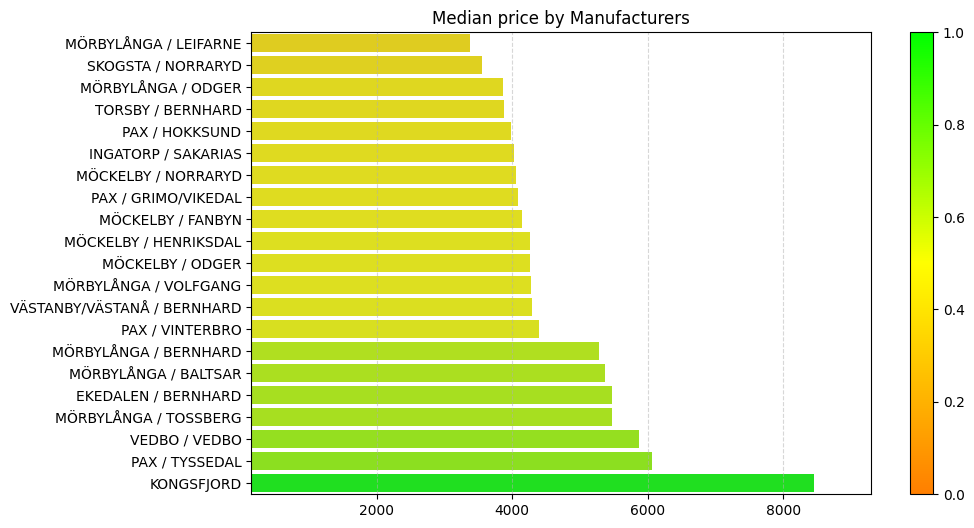

In [10]:
# Median ціна залежно від назви виробника
median_price_name = df.groupby("name")["price"].median().reset_index()
median_price_name = median_price_name.sort_values('price', ascending=False).reset_index(drop=True)
median_price_name = median_price_name.iloc[:21]

# Convert to Markdown
median_price_name_markdown = median_price_name.to_markdown(index=False)
print(median_price_name_markdown)

# Visualization of Median price by Manufacturers
fig, ax = plt.subplots(figsize=(10, 6))
cmap = mcolors.LinearSegmentedColormap.from_list("", ["#FF7F00", "#FFFF00", "#00FF00"])
sns.barplot(x="price", y="name", data=median_price_name,
            palette=cmap(median_price_name['price']/median_price_name['price'].max()),
            orient='horizontal')

sm = plt.cm.ScalarMappable(cmap=cmap)
sm.set_array([])
fig.colorbar(sm, ax=ax)

ax.set_xlim(150, median_price_name['price'].max() * 1.1)
plt.yticks(rotation=0, ha='right', fontsize=10)
plt.title("Median price by Manufacturers")
plt.ylabel("")
plt.xlabel("")
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.5)

# 3.   На основі EDA та вашого здорового глузду виберіть дві гіпотези, які ви хочете перевірити/проаналізувати. Для кожної гіпотези перерахуйте нульову гіпотезу та інші можливі альтернативні гіпотези, 
# розробіть тести для їх розрізнення та виконайте їх. Опишіть результати.

In [ ]:
# Дослідницьке питання 1:
# Чи відрізняється ціна товарів залежно від їх доступності для онлайн-продажу?

# Гіпотеза 1. Онлайн-доступність товару впливає на ціну
# Товари, доступні для онлайн-продажу, мають іншу ціну, ніж недоступні онлайн.

# Нульова гіпотеза (H₀)
# Середні ціни товарів не відрізняються залежно від онлайн-доступності.

# Альтернативна гіпотеза 1 (H₁)
# Товари, доступні онлайн, дорожчі.

# Альтернативна гіпотеза 2 (H₂)
# Товари, доступні онлайн, дешевші.

In [6]:
df.head()

,item_id,name,category,price,old_price,sellable_online,link,other_colors,short_description,designer,depth,height,width
0,90420332,FREKVENS,Bar furniture,265.0,No old price,True,https://www.ikea.com/sa/en/p/frekvens-bar-tabl...,No,"Bar table, in/outdoor, 51x51 cm",Nicholai Wiig Hansen,NaN,99.0,51.0
1,368814,NORDVIKEN,Bar furniture,995.0,No old price,False,https://www.ikea.com/sa/en/p/nordviken-bar-tab...,No,"Bar table, 140x80 cm",Francis Cayouette,NaN,105.0,80.0
2,9333523,NORDVIKEN / NORDVIKEN,Bar furniture,2095.0,No old price,False,https://www.ikea.com/sa/en/p/nordviken-nordvik...,No,Bar table and 4 bar stools,Francis Cayouette,NaN,NaN,NaN
3,80155205,STIG,Bar furniture,69.0,No old price,True,https://www.ikea.com/sa/en/p/stig-bar-stool-wi...,Yes,"Bar stool with backrest, 74 cm",Henrik Preutz,50.0,100.0,60.0
4,30180504,NORBERG,Bar furniture,225.0,No old price,True,https://www.ikea.com/sa/en/p/norberg-wall-moun...,No,"Wall-mounted drop-leaf table, ...",Marcus Arvonen,60.0,43.0,74.0


In [9]:
# прибираємо пропуски по ціні та онлайн-доступності
analysis_df = df[['price', 'sellable_online']].dropna()

# розділяємо на дві групи
online_prices = analysis_df.loc[analysis_df['sellable_online'] == True, 'price']
offline_prices = analysis_df.loc[analysis_df['sellable_online'] == False, 'price']

In [8]:
# Статистичний тест (Mann–Whitney U)

from scipy.stats import mannwhitneyu

u_stat, p_value = mannwhitneyu(online_prices,offline_prices,alternative='two-sided')
u_stat, p_value

(np.float64(69980.5), np.float64(0.0009051612957233146))

In [ ]:
# p-value = 0.0009 < 0.05
# нульову гіпотезу (H₀) відхиляємо
# Тобто:
# ціни товарів статистично значуще відрізняються залежно від онлайн-доступності

In [10]:
online_prices.median(), offline_prices.median()

(np.float64(545.0), np.float64(197.5))

In [10]:
# Тест Манна–Вітні показав статистично значущу різницю в цінах між товарами, доступними онлайн та недоступними онлайн (p < 0.05).
# Отже, онлайн-доступність товару впливає на його ціну.

# Підтверджується Альтернативна гіпотеза 1 (H₁)
# Товари, доступні онлайн, дорожчі.

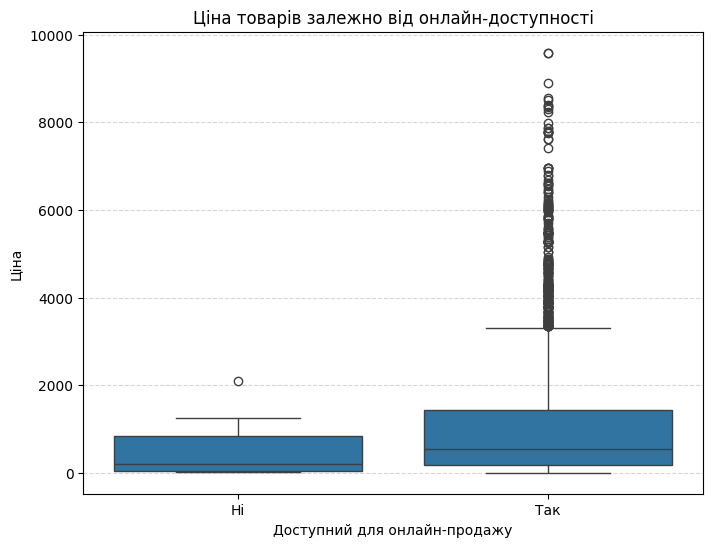

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.boxplot(
    data=analysis_df,
    x='sellable_online',
    y='price'
)

plt.title("Ціна товарів залежно від онлайн-доступності")
plt.xlabel("Доступний для онлайн-продажу")
plt.ylabel("Ціна")
plt.xticks([0, 1], ['Ні', 'Так'])
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()

In [12]:
# Тест: Welch t-test
from scipy.stats import ttest_ind

t_stat, p_value_t = ttest_ind(
    online_prices,
    offline_prices,
    equal_var=False  # Welch t-test
)

t_stat, p_value_t

(np.float64(6.021322242138046), np.float64(1.3705794426779927e-06))

In [13]:
online_prices.mean(), offline_prices.mean()

(np.float64(1083.0403436988545), np.float64(445.57142857142856))

In [ ]:
# Висновок
# Для перевірки впливу онлайн-доступності товару на ціну було застосовано непараметричний тест Манна–Вітні та параметричний Welch t-test.
# Обидва тести показали статистично значущу різницю між цінами товарів, доступних і недоступних для онлайн-продажу (Mann–Whitney p = 0.0009, 
# Welch t-test p = 1.37e-06).
# Додатний знак t-статистики (t = 6.02) свідчить про те, що товари, доступні для онлайн-продажу, мають вищу середню ціну, ніж ті, 
# що недоступні онлайн.
# Таким чином, нульову гіпотезу відхилено, а альтернативну гіпотезу про вплив онлайн-доступності на ціну підтверджено.

In [ ]:
# Дослідницьке питання 2:  Чи відрізняється ціна товарів залежно від популярності дизайнера?
# Гіпотеза 1. Ціна меблів, створених популярними дизайнерами, вища за ціну меблів, створених
# менш відомими дизайнерами.
# Ми можемо визначити популярних дизайнерів як тих, чиї імена з'являються в більш ніж 50% набору
# даних, а менш відомих дизайнерів - як тих, чиї імена з'являються в менш ніж 50% набору даних.
# Нульова гіпотеза: немає істотної різниці в ціні меблів між популярними та менш відомими
# дизайнерами.
# Альтернативна гіпотеза 1: меблі, створені популярними дизайнерами, дорожчі за меблі,
# створені менш відомими дизайнерами.
# Альтернативна гіпотеза 2: меблі, створені менш відомими дизайнерами, дорожчі за меблі, 
# створені популярними дизайнерами

In [16]:
digit_mask =df['designer'].str.contains(r'\d') # знаходимо дизайнерів з цифрами
designers_data =df[~digit_mask].reset_index(drop=True) # залишає лише коректні імена без цифр
 
designers_counts = df['designer'].value_counts()[::-1] # рахує кількість товару по дизайнеру

In [17]:
digit_mask =df['designer'].str.contains(r'\d')
digit_mask

0       False
1       False
2       False
3       False
4       False
        ...  
3689    False
3690    False
3691    False
3692    False
3693    False
Name: designer, Length: 3694, dtype: bool

In [18]:
designers_data =df[~digit_mask].reset_index(drop=True)
designers_data # новий датафрейм

,Unnamed: 0,item_id,name,category,price,old_price,sellable_online,link,other_colors,short_description,designer,depth,height,width
0,0,90420332,FREKVENS,Bar furniture,265.0,No old price,True,https://www.ikea.com/sa/en/p/frekvens-bar-tabl...,No,"Bar table, in/outdoor, 51x51 cm",Nicholai Wiig Hansen,NaN,99.0,51.0
1,1,368814,NORDVIKEN,Bar furniture,995.0,No old price,False,https://www.ikea.com/sa/en/p/nordviken-bar-tab...,No,"Bar table, 140x80 cm",Francis Cayouette,NaN,105.0,80.0
2,2,9333523,NORDVIKEN / NORDVIKEN,Bar furniture,2095.0,No old price,False,https://www.ikea.com/sa/en/p/nordviken-nordvik...,No,Bar table and 4 bar stools,Francis Cayouette,NaN,NaN,NaN
3,3,80155205,STIG,Bar furniture,69.0,No old price,True,https://www.ikea.com/sa/en/p/stig-bar-stool-wi...,Yes,"Bar stool with backrest, 74 cm",Henrik Preutz,50.0,100.0,60.0
4,4,30180504,NORBERG,Bar furniture,225.0,No old price,True,https://www.ikea.com/sa/en/p/norberg-wall-moun...,No,"Wall-mounted drop-leaf table, ...",Marcus Arvonen,60.0,43.0,74.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3546,3689,99157902,ELVARLI,Wardrobes,750.0,SR 820,True,https://www.ikea.com/sa/en/p/elvarli-1-section...,No,"1 section, 92x51x222-350 cm",Ehlén Johansson,50.0,NaN,91.0
3547,3690,9158152,ELVARLI,Wardrobes,1572.0,"SR 1,755",True,https://www.ikea.com/sa/en/p/elvarli-2-section...,No,"2 sections, 135x51x222-350 cm",Ehlén Johansson,50.0,NaN,135.0
3548,3691,59157541,ELVARLI,Wardrobes,924.0,"SR 1,050",True,https://www.ikea.com/sa/en/p/elvarli-2-section...,No,"2 sections, 175x51x222-350 cm",Ehlén Johansson,50.0,NaN,175.0
3549,3692,89157573,ELVARLI,Wardrobes,2745.0,"SR 3,130",True,https://www.ikea.com/sa/en/p/elvarli-3-section...,No,"3 sections, 178x51x222-350 cm",Ehlén Johansson,50.0,NaN,178.0


In [19]:
designers_data['designer'].str.contains(r'\d', na=False).sum() # перевірка коду

np.int64(0)

In [23]:
designers_counts = designers_data['designer'].value_counts()[::-1]
designers_counts

designer
IKEA of Sweden/Ehlén Johansson/Andreas Fredriksson      1
IKEA of Sweden/Chenyi Ke/Johanna Asshoff                1
Carl Öjerstam/Marcus Arvonen/IKEA of Sweden             1
Gillis Lundgren/IKEA of Sweden/K Hagberg/M Hagberg      1
Francis Cayouette/IKEA of Sweden/Ehlén Johansson        1
                                                     ... 
K Hagberg/M Hagberg                                   122
Ola Wihlborg                                          134
Francis Cayouette                                     151
Ehlén Johansson                                       161
IKEA of Sweden                                        828
Name: count, Length: 279, dtype: int64

In [21]:
# Обчислити суму підрахунків
sum_of_counts = designers_counts.sum()
sum_of_counts

np.int64(3551)

In [22]:
# Обчислити сукупну суму відсотків (Це дизайнери, які разом створюють 50% товарів, накопичувальний відстоток)
cumulative_percentage = designers_counts.cumsum() / sum_of_counts
cumulative_percentage

designer
IKEA of Sweden/Ehlén Johansson/Andreas Fredriksson    0.000282
IKEA of Sweden/Chenyi Ke/Johanna Asshoff              0.000563
Carl Öjerstam/Marcus Arvonen/IKEA of Sweden           0.000845
Gillis Lundgren/IKEA of Sweden/K Hagberg/M Hagberg    0.001126
Francis Cayouette/IKEA of Sweden/Ehlén Johansson      0.001408
                                                        ...   
K Hagberg/M Hagberg                                   0.641228
Ola Wihlborg                                          0.678964
Francis Cayouette                                     0.721487
Ehlén Johansson                                       0.766826
IKEA of Sweden                                        1.000000
Name: count, Length: 279, dtype: float64

In [24]:
# Знайти дизайнерів, які складають 50% від загальної кількості
famous_designers = designers_counts[cumulative_percentage > 0.5][::-1]

print(f'Відомі дизайнери, які складають 50% від загальної кількості:')
print(famous_designers)

famous_designers_data = designers_data[designers_data["designer"].isin(famous_designers.index)]
less_known_designers_data = designers_data[~designers_data["designer"].isin(famous_designers.index)]

Відомі дизайнери, які складають 50% від загальної кількості:
designer
IKEA of Sweden                    828
Ehlén Johansson                   161
Francis Cayouette                 151
Ola Wihlborg                      134
K Hagberg/M Hagberg               122
Jon Karlsson                      120
Carina Bengs                       75
Ehlén Johansson/IKEA of Sweden     75
Henrik Preutz                      70
IKEA of Sweden/Ehlén Johansson     70
Name: count, dtype: int64


In [25]:
#1) t-test - якщо ціни мають нормальний розподіл
from scipy.stats import shapiro
shapiro_famous = shapiro(famous_designers_data['price'])
shapiro_less = shapiro(less_known_designers_data['price'])

shapiro_famous, shapiro_less

(ShapiroResult(statistic=np.float64(0.7232037058366424), pvalue=np.float64(1.2992189146911237e-47)),
 ShapiroResult(statistic=np.float64(0.7539625662250019), pvalue=np.float64(3.761247524653172e-45)))

In [ ]:
# p-value > 0.05  - розподіл близький до нормального
# p-value ≤ 0.05  - не нормальний
# Якщо хоча б одна група не нормальна - t-test не бажаний

In [26]:
t_stat, p_value = ttest_ind(famous_designers_data['price'],less_known_designers_data['price'],equal_var=False)
t_stat, p_value

(np.float64(-5.12565425886154), np.float64(3.1280977119593965e-07))

In [27]:
famous_designers_data['price'].mean(), less_known_designers_data['price'].mean()

(np.float64(989.1934108527132), np.float64(1228.3700859598853))

In [28]:
famous_designers_data['price'].median(), less_known_designers_data['price'].median()

(np.float64(495.0), np.float64(615.0))

In [ ]:
# За результатами Welch t-test (t = −5.13, p < 0.001) виявлено статистично значущу різницю в цінах 
# між меблями відомих та менш відомих дизайнерів.
# Середня ціна меблів менш відомих дизайнерів є вищою, ніж у меблів відомих дизайнерів.
# Альтернативна гіпотеза 1 не підтвердилася
# Альтернативна гіпотеза 2 підтвердилася
# Дані показують, що бренд/масовість не гарантує вищу ціну

In [34]:
# 2) Mann–Whitney - якщо ненормальний 
from scipy.stats import mannwhitneyu
u_stat, p_value = mannwhitneyu(
    famous_designers_data['price'],
    less_known_designers_data['price'],
    alternative='two-sided'
)
u_stat, p_value

(np.float64(1382035.0), np.float64(2.266160121725664e-10))

In [ ]:
# Для перевірки впливу популярності дизайнера на ціну меблів було застосовано непараметричний тест Манна–Вітні, оскільки розподіл цін відрізняється 
# від нормального.
# Результати тесту свідчать про статистично значущу різницю між цінами меблів відомих та менш відомих дизайнерів (U = 1 382 035, p < 0.001).
# Порівняння медіан показало, що  меблі менш відомих (615) в порівнянні з відомимими дизайнерів мають вищу медіанну ціну (495)

In [33]:
famous_designers_data['price'].median(), less_known_designers_data['price'].median()

(np.float64(495.0), np.float64(615.0))

In [25]:
famous_designers_data['price'].describe()
less_known_designers_data['price'].describe()

count    1745.000000
mean     1228.370086
std      1480.385982
min         3.000000
25%       260.000000
50%       615.000000
75%      1636.000000
max      9585.000000
Name: price, dtype: float64

C:\Users\ASUS\AppData\Local\Temp\ipykernel_15260\2482054173.py:1: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


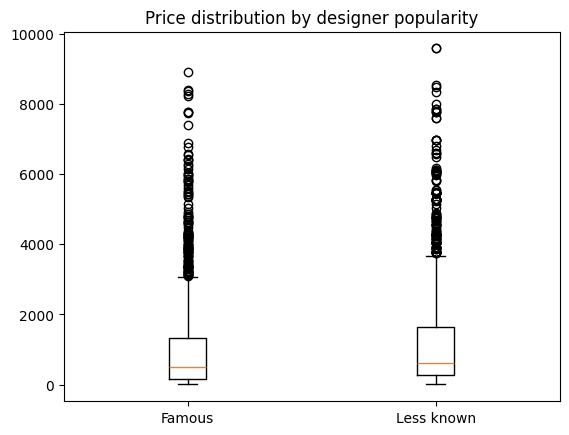

In [26]:
plt.boxplot(
    [famous_designers_data['price'], less_known_designers_data['price']],
    labels=['Famous', 'Less known'])
plt.title('Price distribution by designer popularity')
plt.show()

In [ ]:
# # Висновок

# # У межах дослідження було перевірено гіпотезу про те, що меблі, створені популярними дизайнерами, мають вищу ціну порівняно з меблями менш відомих 
# # дизайнерів.
# #Обидва статистичні тести - як параметричний (t-test), так і непараметричний (Манна–Вітні) — узгоджено показали наявність 
# статистично значущої різниці в цінах між меблями відомих та менш відомих дизайнерів.

# Таким чином:
#  • Нульова гіпотеза (H₀) про відсутність різниці в цінах відхиляється.
#  • Дані не підтверджують припущення, що меблі відомих дизайнерів дорожчі.
#  • Навпаки, результати свідчать, що меблі менш відомих дизайнерів у середньому мають вищу ціну.

# 4.Навчіть модель передбачати ціну меблів. Зазначте, які стовпці не слід включати до моделі і чому. Створіть конвеєр перехресної перевірки для навчання та оцінки моделі, включаючи (за необхідності) такі кроки, як заповнення пропущених значень та нормалізація. 
# Запропонуйте методи покращення продуктивності моделі. Опишіть результати.


In [ ]:
# Завдання: прогнозування ціни меблів
# Мета: Навчити модель машинного навчання передбачати ціну меблів (price) на основі характеристик товару.

In [ ]:
# Перед навчанням моделі ми повинні виключити непотрібні стовпці, такі як:
# index - технічний індекс, не несе інформації
# item_id- унікальний ідентифікатор, не має зв’язку з ціною
# link- URL, неінформативний
# old_price - сильно корелює з price → ризик мультиколінеарності
# name - висококардинальна текстова ознака
# designer -текст, потребує складної обробки (можна використати пізніше)

In [ ]:
# 1) RandomForestRegressor

In [29]:
df.columns

Index(['item_id', 'name', 'category', 'price', 'old_price', 'sellable_online',
       'link', 'other_colors', 'short_description', 'designer', 'depth',
       'height', 'width', 'designer_clean1', 'designer_clean2',
       'designer_clean'],
      dtype='object')

In [30]:
from sklearn.ensemble import RandomForestRegressor
X = df.drop(columns=[
    'price', 'old_price', 'item_id', 'link', 'name', 'short_description', 'sellable_online', 'designer', 'designer_clean1','designer_clean'])
y = df['price']

In [31]:
def make_preprocessor(numeric_features, categorical_features): # Створює єдиний ColumnTransformer для всіх моделей
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', SimpleImputer(strategy='median'), numeric_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)])
    return preprocessor

In [32]:
numeric_features = [
    'height', 'width', 'depth']

categorical_features = ['category','designer_clean2']

In [33]:
preprocessor = make_preprocessor(
    numeric_features=numeric_features,
    categorical_features=categorical_features
)

In [34]:
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),('model', RandomForestRegressor(random_state=42,n_estimators=200,n_jobs=-1))])

In [39]:
X = df[numeric_features + categorical_features]
y = df['price']

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2,random_state=42)

In [37]:
model_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('rf_regressor', RandomForestRegressor(random_state=42))
])

model_rf.fit(X_train, y_train)

y_rf_pred = model_rf.predict(X_test)

rmse_rf = np.sqrt(np.mean((y_rf_pred - y_test)**2))
print('RandomForestRegressor RMSE: {:.2f}'.format(rmse_rf))

mse_rf = np.mean((y_rf_pred - y_test)**2)
print('RandomForestRegressor Mean Squared Error: {:.2f}'.format(mse_rf))

RandomForestRegressor RMSE: 652.76
RandomForestRegressor Mean Squared Error: 426090.53


In [38]:
from sklearn.metrics import r2_score

r2_rf = r2_score(y_test, y_rf_pred)
print(f"RandomForest R²: {r2_rf:.3f}")

RandomForest R²: 0.779


In [43]:
df["price"].describe()

count    3694.000000
mean     1078.208419
std      1374.652494
min         3.000000
25%       180.900000
50%       544.700000
75%      1429.500000
max      9585.000000
Name: price, dtype: float64

In [ ]:
# Модель RandomForestRegressor продемонструвала високу пояснювальну здатність (R² = 0.779), що свідчить про правильне захоплення ключових факторів
# ціноутворення. Водночас абсолютна похибка прогнозу (RMSE ≈ 653) перевищує медіану ціни (500), що вказує на нерівномірну точність моделі в різних 
# цінових сегментах. Це свідчить про доцільність 
# логарифмування цільової змінної або використання альтернативних метрик помилки.

In [ ]:
# 2) LinearRegression

In [44]:
from sklearn.metrics import r2_score

In [45]:
model_regression = Pipeline(steps=[('preprocessor', preprocessor),
    ('regressor', LinearRegression())])

model_regression.fit(X_train, y_train)

y_regression_pred = model_regression.predict(X_test)

rmse_regression = np.sqrt(np.mean((y_regression_pred - y_test)**2))
print('LinearRegression RMSE: {:.2f}'.format(rmse_regression))

mse_regression = np.mean((y_regression_pred - y_test)**2)
print('LinearRegression Mean Squared Error: {:.2f}'.format(mse_regression))

LinearRegression RMSE: 899.20
LinearRegression Mean Squared Error: 808556.41


In [ ]:
# Лінійна регресія показала значно гірші результати (RMSE ≈ 899) у порівнянні з моделями на основі дерев. Це свідчить про нелінійний
# характер залежностей у даних та підтверджує доцільність використання ансамблевих методів для 
# прогнозування ціни меблів.

In [46]:
from sklearn.metrics import r2_score

r2_lr = r2_score(y_test, y_regression_pred)
print(f"LinearRegression R²: {r2_lr:.3f}")

LinearRegression R²: 0.581


In [ ]:
# Лінійна регресія демонструє помірну пояснювальну здатність (R² = 0.58), що свідчить про наявність нелінійних залежностей у даних. 
# Моделі на основі дерев рішень (RandomForest) значно краще моделюють 
# структуру даних та забезпечують вищу точність прогнозу.

In [47]:
model_regression.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


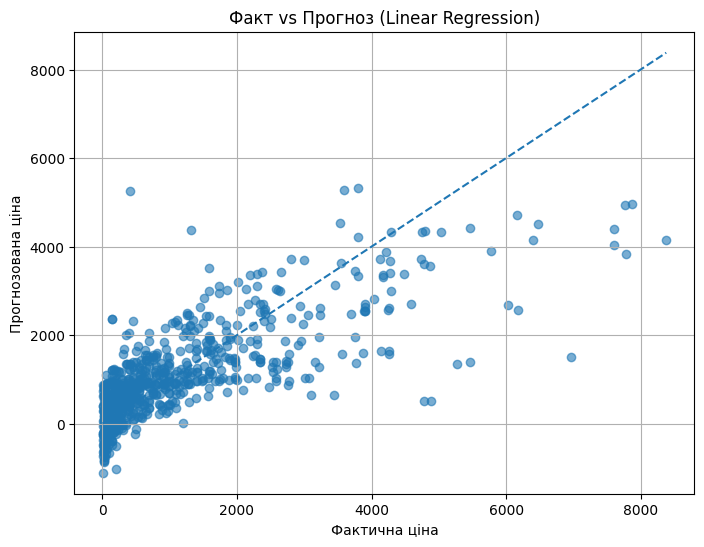

In [51]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_regression_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         linestyle='--')

plt.xlabel("Фактична ціна")
plt.ylabel("Прогнозована ціна")
plt.title("Факт vs Прогноз (Linear Regression)")
plt.grid(True)
plt.show()
# ідеальна модель → точки на діагоналі
# відхилення → помилки про

In [ ]:
 # 3) GradientBoostingRegressor

In [52]:
model_gradientboost = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('gradientboost_regressor', GradientBoostingRegressor(random_state=42))
])

model_gradientboost.fit(X_train, y_train)

y_gradientboost_pred = model_gradientboost.predict(X_test)

rmse_gradientboost = np.sqrt(np.mean((y_gradientboost_pred - y_test)**2))
print('GradientBoostingRegressor RMSE: {:.2f}'.format(rmse_gradientboost))

mse_gradientboost = np.mean((y_gradientboost_pred - y_test)**2)
print('GradientBoostingRegressor Mean Squared Error: {:.2f}'.format(mse_gradientboost))

GradientBoostingRegressor RMSE: 774.16
GradientBoostingRegressor Mean Squared Error: 599316.21


In [54]:
r2_gbr = r2_score(y_test, y_gradientboost_pred)
print(f"GradientBoosting R²: {r2_gbr:.3f}")

GradientBoosting R²: 0.689


In [ ]:
# Вибір найкращої моделі
# Фінальна модель: RandomForestRegressor
# Причини вибору:
#  - Найменший RMSE
#  - Найвищий R²
#  - Найкраще узагальнення
#  - Підходить для задач прогнозування ціни

In [ ]:
# Візуалізація порівняння моделей

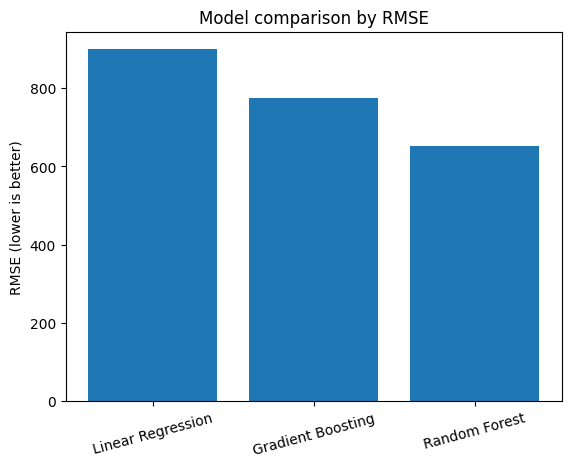

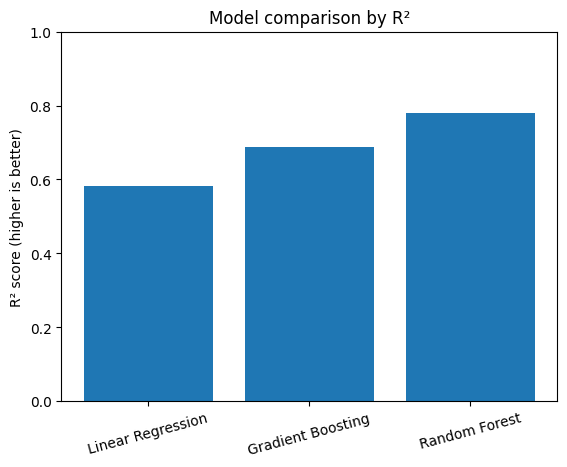

In [55]:
import matplotlib.pyplot as plt
import pandas as pd

# результати моделей
results = pd.DataFrame({
    "Model": ["Linear Regression", "Gradient Boosting", "Random Forest"],
    "RMSE": [899.20, 774.16, 652.76],
    "R2": [0.581, 0.689, 0.779]
})

# --- RMSE ---
plt.figure()
plt.bar(results["Model"], results["RMSE"])
plt.title("Model comparison by RMSE")
plt.ylabel("RMSE (lower is better)")
plt.xticks(rotation=15)
plt.show()

# --- R² ---
plt.figure()
plt.bar(results["Model"], results["R2"])
plt.title("Model comparison by R²")
plt.ylabel("R² score (higher is better)")
plt.xticks(rotation=15)
plt.ylim(0, 1)
plt.show()

In [ ]:
# Порівняння трьох моделей машинного навчання показало, що RandomForestRegressor демонструє найкращі
# результати з точки зору як точності прогнозування (RMSE), так і пояснювальної здатності (R²). 
# Лінійна регресія виявилася найслабшою моделлю, тоді як GradientBoostingRegressor зайняв проміжне місце. На основі отриманих результатів RandomForestRegressor був обраний 
# як фінальна модель для прогнозування цін меблів.

In [ ]:
# GridSearchCV для RandomForestRegressor

In [ ]:
# Сітка гіперпараметрів

In [30]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

param_grid = {
    'rf_regressor__n_estimators': [100, 200],
    'rf_regressor__max_depth': [None, 10, 20],
    'rf_regressor__min_samples_split': [2, 5],
    'rf_regressor__min_samples_leaf': [1, 2]
}

In [ ]:
# GridSearchCV

In [48]:
grid_search = GridSearchCV(
    estimator=model_rf,
    param_grid=param_grid,
    scoring='r2',
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'rf_regressor__max_depth': [None, 10, ...], 'rf_regressor__min_samples_leaf': [1, 2], 'rf_regressor__min_samples_split': [2, 5], 'rf_regressor__n_estimators': [100, 200]}"
,scoring,'r2'
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('num', ...), ('cat', ...)]"


In [ ]:
# Найкраща модель

In [49]:
best_model = grid_search.best_estimator_

grid_search.best_params_, grid_search.best_score_

({'rf_regressor__max_depth': None,
  'rf_regressor__min_samples_leaf': 1,
  'rf_regressor__min_samples_split': 5,
  'rf_regressor__n_estimators': 200},
 np.float64(0.7768472207304276))

In [ ]:
# Навчання та тестування найкращої моделі

In [50]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

y_pred_best = best_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred_best)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_best))
r2 = r2_score(y_test, y_pred_best)

mae, rmse, r2

(334.4083551810413, np.float64(645.473094727719), 0.7838451509071567)

In [ ]:
# Графік «Факт vs Прогноз»

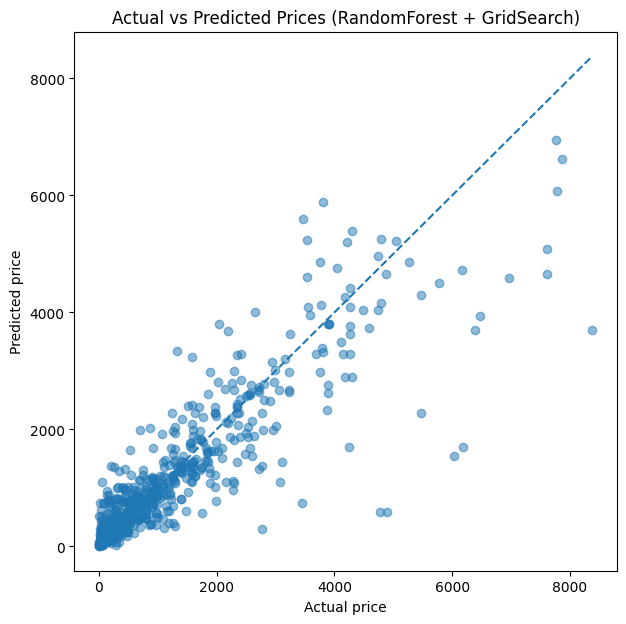

In [60]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 7))
plt.scatter(y_test, y_pred_best, alpha=0.5)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         linestyle='--')

plt.xlabel("Actual price")
plt.ylabel("Predicted price")
plt.title("Actual vs Predicted Prices (RandomForest + GridSearch)")
plt.show()

In [ ]:
# Після підбору гіперпараметрів за допомогою GridSearchCV модель RandomForestRegressor продемонструвала покращені показники якості прогнозування:
#  • MAE = 334.41 — у середньому прогнозована ціна відрізняється від фактичної приблизно на 334 грн, що є прийнятним відхиленням з огляду 
# на медіану ціни ~500 грн.
#  • RMSE = 645.47 — більші помилки присутні, але вони очікувані для товарів з вищою ціною.
#  • R² = 0.784 — модель пояснює близько 78% варіації ціни, що свідчить про добру здатність до узагальнення та стабільність прогнозів.

# У порівнянні з іншими протестованими моделями (LinearRegression та GradientBoostingRegressor), 
# RandomForestRegressor залишається найкращою моделлю за показником R² та балансом між помилкою і стабільністю.

# Отримані результати підтверджують доцільність використання RandomForestRegressor з підібраними 
# гіперпараметрами для прогнозування ціни товарів у даному наборі даних.

In [ ]:
# Cross-validation (надійна оцінка якості)

In [51]:
from sklearn.model_selection import cross_val_score

# беремо найкращу модель після GridSearchCV
best_rf = grid_search.best_estimator_

# 5-кратна крос-валідація за R²
cv_scores = cross_val_score(
    best_rf,
    X,
    y,
    cv=5,
    scoring='r2',
    n_jobs=-1
)

print("R² по фолдах:", cv_scores)
print("Середній R²:", cv_scores.mean())
print("Стандартне відхилення:", cv_scores.std())

R² по фолдах: [0.73687929 0.3756522  0.45338851 0.67836881 0.2594242 ]
Середній R²: 0.5007425984099695
Стандартне відхилення: 0.18079612625670027


In [ ]:
# Scatter plot (ідеальний графік для регресії)
# Візуалізація: факт vs прогноз

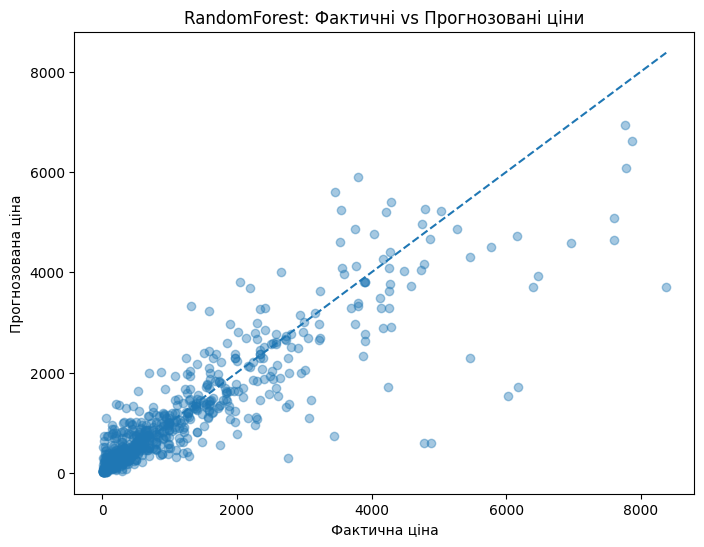

In [52]:
import matplotlib.pyplot as plt

# прогноз
y_pred = best_rf.predict(X_test)

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.4)
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    linestyle='--'
)
plt.xlabel("Фактична ціна")
plt.ylabel("Прогнозована ціна")
plt.title("RandomForest: Фактичні vs Прогнозовані ціни")
plt.show()

In [ ]:
# boxplot R² по фолдах

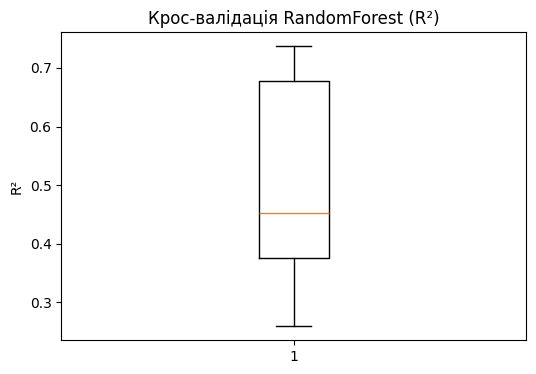

In [53]:
plt.figure(figsize=(6, 4))
plt.boxplot(cv_scores)
plt.ylabel("R²")
plt.title("Крос-валідація RandomForest (R²)")
plt.show()

In [ ]:
# Крос-валідація показала значну варіативність значень R² між фолдами (від 0.26 до 0.74). 
# Середній R² становить 0.50 при стандартному відхиленні 0.18, що свідчить про нестабільність моделі на 
# різних підвибірках. Це може бути зумовлено нерівномірним розподілом цін та високою кардинальністю категоріальних ознак. 
# Таким чином, результати GridSearchCV необхідно інтерпретувати з обережністю.

In [ ]:
# Дослідження впливу факторів (Feature Importance)

In [39]:
feature_names = model_rf.named_steps['preprocessor'].get_feature_names_out()
importances = model_rf.named_steps['rf_regressor'].feature_importances_

fi_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

In [ ]:
# ГРУПУВАННЯ категоріальних факторів

In [40]:
def group_feature(feature):
    if feature.startswith('num__'):
        return feature.replace('num__', '')
    elif feature.startswith('cat__designer'):
        return 'designer'
    elif feature.startswith('cat__category'):
        return 'category'
    else:
        return 'other'

fi_df['group'] = fi_df['feature'].apply(group_feature)

In [41]:
grouped_fi = (
    fi_df
    .groupby('group')['importance']
    .sum()
    .sort_values(ascending=False)
)

grouped_fi

group
width       0.572819
depth       0.135455
designer    0.130324
category    0.082208
height      0.079194
Name: importance, dtype: float64

In [ ]:
# Аналіз важливості ознак, виконаний на основі найкращої моделі RandomForestRegressor, показав, що ціна меблів найбільше залежить 
# від фізичних характеристик товару, зокрема:
# Ширина (width) є домінуючим фактором і пояснює понад 57% загальної важливості моделі. Це свідчить про те, що 
# габарити виробу мають ключове значення для формування ціни.
# Глибина (depth) також має суттєвий вплив (≈13.5%), підтверджуючи важливість розміру меблів.
# Дизайнер (designer) забезпечує ≈13% впливу, що вказує на бренд-ефект і нематеріальну складову ціни.
# Категорія товару (category) та висота (height) мають помірний, але стабільний вплив на вартість.

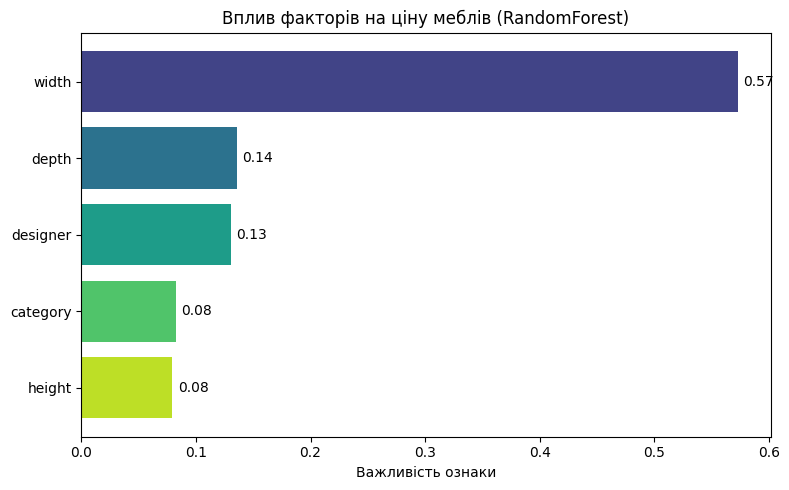

In [42]:
import matplotlib.pyplot as plt
import numpy as np

# Дані
groups = grouped_fi.index
values = grouped_fi.values

# Градієнт кольорів
colors = plt.cm.viridis(np.linspace(0.2, 0.9, len(values)))

plt.figure(figsize=(8, 5))
bars = plt.barh(groups, values, color=colors)

plt.xlabel('Важливість ознаки')
plt.title('Вплив факторів на ціну меблів (RandomForest)')
plt.gca().invert_yaxis()

# Додавання значень на графік
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.005, bar.get_y() + bar.get_height()/2,
             f'{width:.2f}', va='center')

plt.tight_layout()
plt.show()